Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Global Epoch 1/10
Global Model Test Accuracy after round 1: 94.51%
Global Epoch 2/10
Global Model Test Accuracy after round 2: 96.65%
Global Epoch 3/10
Global Model Test Accuracy after round 3: 96.65%
Global Epoch 4/10
Global Model Test Accuracy after round 4: 97.23%
Global Epoch 5/10
Global Model Test Accuracy after round 5: 97.61%
Global Epoch 6/10
Global Model Test Accuracy after round 6: 97.78%
Global Epoch 7/10
Global Model Test Accuracy after round 7: 97.89%
Global Epoch 8/10
Global Model Test Accuracy after round 8: 97.96%
Global Epoch 9/10
Global Model Test Accuracy after round 9: 97.94%
Global Epoch 10/10
Global Model Test Accuracy after round 10: 98.01%
Federated learning process completed. Model saved as 'federated_mnist_model.pth'.


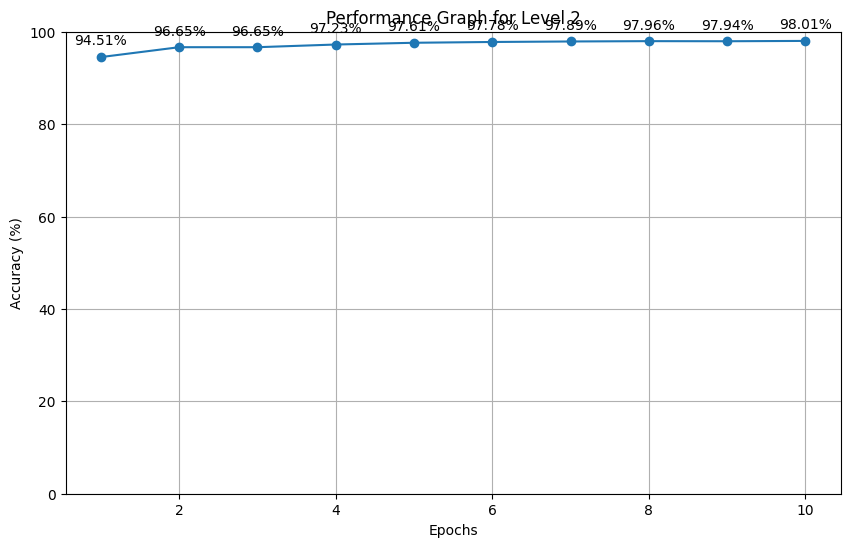

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import copy

# Define the CNN Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # MNIST: 1 channel input
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust for MNIST 28x28 -> 7x7 after pooling
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Load MNIST dataset
def load_data(transform):
    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Partition the dataset for each client
def partition_dataset(dataset, n_clients=10):
    split_size = len(dataset) // n_clients
    return random_split(dataset, [split_size] * n_clients)

# Client-side local training
def client_update(client_model, optimizer, train_loader, device, epochs=1):
    client_model.train()
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.cross_entropy(output, labels)
            loss.backward()
            optimizer.step()

# Server-side model aggregation
def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

# Test the global model
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100  # Return accuracy in percentage

# Federated Learning Process
def federated_learning(n_clients=10, global_epochs=10, local_epochs=2):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log_file = "level2_training.log"

    # Data transformation
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Load data and partition for clients
    train_dataset, test_dataset = load_data(transform)
    client_datasets = partition_dataset(train_dataset, n_clients)
    client_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Initialize global model and client models
    global_model = ConvNet().to(device)
    client_models = [copy.deepcopy(global_model) for _ in range(n_clients)]
    optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in client_models]

    accuracy_values = []

    # Federated learning loop
    for global_epoch in range(global_epochs):
        print(f"Global Epoch {global_epoch + 1}/{global_epochs}")

        # Each client trains locally
        for client_idx in range(n_clients):
            client_update(client_models[client_idx], optimizers[client_idx], client_loaders[client_idx], device, local_epochs)

        # Server aggregates models
        server_aggregate(global_model, client_models)

        # Test global model
        test_accuracy = test_model(global_model, test_loader, device)
        accuracy_values.append(test_accuracy)  # Store accuracy in percentage
        print(f"Global Model Test Accuracy after round {global_epoch + 1}: {test_accuracy:.2f}%")

        # Log the accuracy
        with open(log_file, "a") as log:
            log.write(f"Global Model Test Accuracy after round {global_epoch + 1}: {test_accuracy:.2f}%\n")

    # Save the global model
    torch.save(global_model.state_dict(), 'federated_mnist_model.pth')
    print("Federated learning process completed. Model saved as 'federated_mnist_model.pth'.")

    return accuracy_values

# Plot the performance graph
def plot_individual_level_graph(level_name, accuracy_values, save_path):
    """
    Plots a performance graph for a single level and saves the graph as an image.

    :param level_name: Name of the level (e.g., 'Level 2')
    :param accuracy_values: List of accuracy values over epochs
    :param save_path: File path to save the graph
    """
    if not accuracy_values:
        print(f"No accuracy data to plot for {level_name}")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o')
    plt.title(f"Performance Graph for {level_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)

    # Annotate each point with its accuracy value
    for i, acc in enumerate(accuracy_values):
        plt.text(i + 1, acc + 2, f"{acc:.2f}%", ha='center', va='bottom')

    plt.savefig(save_path)
    plt.show()

# Download files function
def download_files():
    from google.colab import files
    files_to_download = ["level2_training.log", "federated_mnist_model.pth", "performance_graph_level2.png"]
    for file in files_to_download:
        if os.path.exists(file):
            print(f"Downloading {file}...")
            files.download(file)
        else:
            print(f"File {file} not found, skipping download.")

# Run the federated learning process and plot the graph
if __name__ == "__main__":
    accuracy_level_2 = federated_learning(n_clients=10, global_epochs=10, local_epochs=2)
    plot_individual_level_graph("Level 2", accuracy_level_2, "performance_graph_level2.png")
    download_files()
